<a href="https://colab.research.google.com/github/Abhishek-Gargha-Maheshwarappa/Abhishek-Gargha-Maheshwarappa/blob/master/AD_Campaing_modeling_with_Reinforcemnet_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ad campaing 
Click impression
No click No impression

First we setup the necessary imports and the standard Ads. The get_reward_regret samples the reward for the given action, and returns the regret based on the true best action.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, ad_camp):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.ad_camp = ad_camp
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.ad_camp)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for ad. Assumes actions are 0-indexed
    Args:
      ad_camp is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.ad_camp)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

In [2]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.ad_camp = bandit.ad_camp
    self.alpha = np.ones(self.ad_camp)
    self.beta = np.ones(self.ad_camp)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()


In [3]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.ad_camp = bandit.ad_camp
    self.Q = np.zeros(self.ad_camp) # q-value of actions
    self.N = np.zeros(self.ad_camp) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.ad_camp)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [4]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.ad_camp = bandit.ad_camp
    self.Q = np.zeros(self.ad_camp) # q-value of actions
    self.N = np.zeros(self.ad_camp) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.ad_camp, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [5]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, ad_camp, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(ad_camp)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(ad_camp, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, ad_camp, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

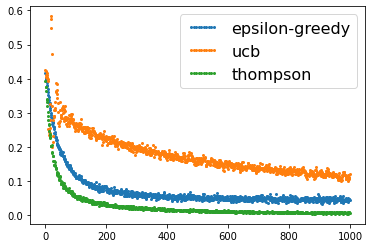

In [6]:
# Experiment 1
ad_camp = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(ad_camp)

# New Section

Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important (15 Points) 


# **1. Thompson Sampling Hyperparameter**



1.   Distrubution beta, uniform or other 


#**2. e-greedy**



1.  Epsilon
2.  Decay rate


#**3. UBC**



1.  C -  uncertainty measure is weighed by the hyperparameter  





By changing the epsilon which Exploration rate

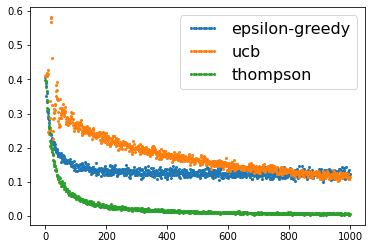

In [7]:
# Experiment 1
ad_camp = 10 # number of arms in bandit
epsilon = 0.3
ucb_c = 2
stationary=True
experiment(ad_camp)

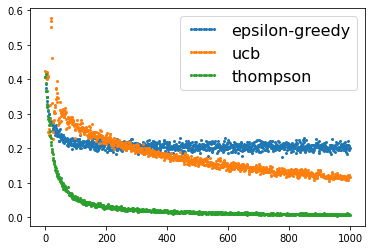

In [8]:
# Experiment 1
ad_camp = 10 # number of arms in bandit
epsilon = 0.5
ucb_c = 2
stationary=True
experiment(ad_camp)

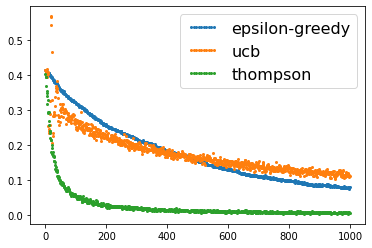

In [9]:
# Experiment 1
ad_camp = 10 # number of arms in bandit
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(ad_camp)

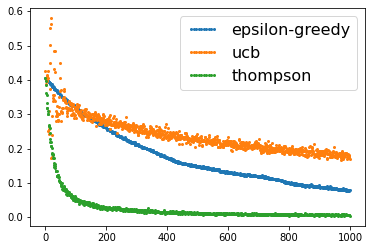

In [10]:
# Experiment 1
ad_camp = 10 # number of arms in bandit
epsilon = 0.01
ucb_c = 3
stationary=True
experiment(ad_camp)

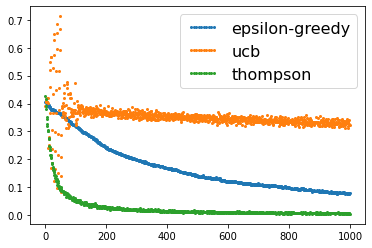

In [11]:
# Experiment 1
ad_camp = 10 # number of arms in bandit
epsilon = 0.01
ucb_c = 10
stationary=True
experiment(ad_camp)

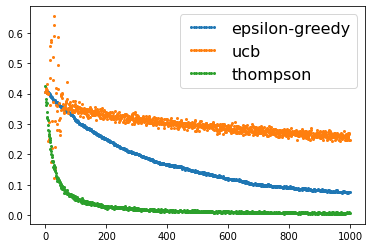

In [12]:
# Experiment 1
ad_camp = 10 # number of arms in bandit
epsilon = 0.01
ucb_c = 5
stationary=True
experiment(ad_camp)

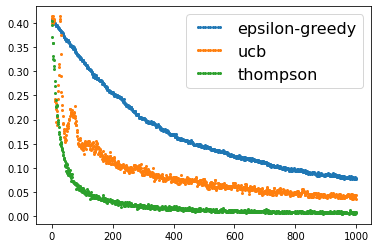

In [13]:
# Experiment 1
ad_camp = 10 # number of arms in bandit
epsilon = 0.01
ucb_c = 1
stationary=True
experiment(ad_camp)

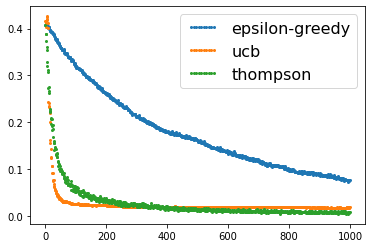

In [14]:
# Experiment 1
ad_camp = 10 # number of arms in bandit
epsilon = 0.01
ucb_c = 0.1
stationary=True
experiment(ad_camp)

How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling?

The action space can be changed by changing the number of ads 

## **Ad_campaing =** 10

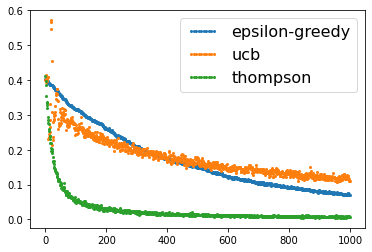

In [17]:
# Experiment 1
ad_camp = 10 
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(ad_camp)

## **Ad_campaing =** 15

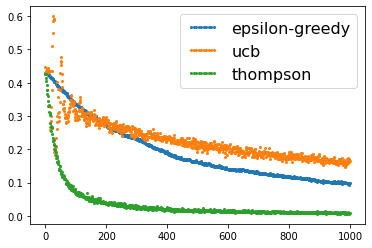

In [18]:
# Experiment 2
ad_camp = 15 
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(ad_camp)

Ad_campaing = 25

In [ ]:
# Experiment 3
ad_camp = 25 
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(ad_camp)

## **Ad_campaing =** 5

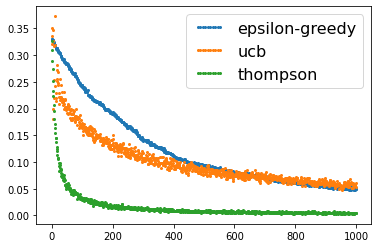

In [19]:
# Experiment 4
ad_camp = 5 
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(ad_camp)

Copyright 2020 Abhishek Maheshwarappa

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.